# Cross-tissue

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
# from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
# figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_Embedding_methods/'
# if not os.path.exists(figdir):
#     os.mkdir(figdir)

### Prep case-control dataset

See `HLCA_prep_designs.ipynb`

In [10]:
adata = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/HLCA/Kaminski_2020_emb_LCAv2.annotated.with_counts.h5ad')

In [17]:
## Subset to healthy patients
adata = adata[adata.obs['Disease_Identity'] == 'Control'].copy()

AnnData object with n_obs × n_vars = 95303 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'Celltype_HLCA'
    var: 'Ensembl_GeneID'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

#### Pick cell types for simulation

In [34]:
oor_cts = ['Alveolar macrophages', 'NK cells', 'AT2', 'Adventitial fibroblasts', 'Lymphatic EC', 'DC2']

In [40]:
adata.obs['cell_annotation'] = ['Lymphatic EC' if x.startswith('Lymphatic EC') else x for x in adata.obs['Celltype_HLCA']]
adata.obs['sample_id'] = adata.obs['Library_Identity']

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


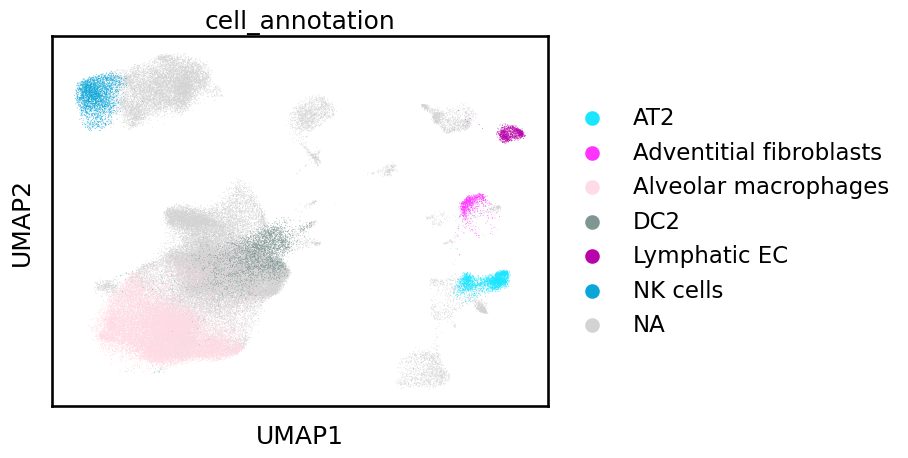

In [41]:
sc.pl.umap(adata, color='cell_annotation', groups=oor_cts)

In [42]:
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.api import check_dataset

In [47]:
split_seed = 2020
np.random.seed(split_seed)
all_samples = adata.obs['sample_id'].unique()
query_samples = np.random.choice(all_samples, size=int(len(all_samples)/2), replace=False)
ctrl_samples = all_samples[~all_samples.isin(query_samples)]

In [48]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [55]:
adata.obs['cell_type_clean'] = adata.obs['cell_annotation'].str.replace(" ", '_').str.replace("-", '_').str.replace(",", '')
oor_cts = [x.replace(" ", '_').replace("-", '_').replace(",", '') for x in oor_cts]

annotation_col = 'cell_type_clean'

for ct in oor_cts:
    print(ct)
    adata = simulate_query_reference(
        adata, query_annotation=[ct],
        annotation_col=annotation_col, 
        batch_col='sample_id',
        query_batch = query_samples.tolist(),
        ctrl_batch = ctrl_samples.tolist(),
    )

    # Save intermediate files
    sim_id = f"Kaminski2020_lung_{annotation_col}{ct}_seed{split_seed}/"
    if not os.path.exists(outdir + sim_id):
        os.mkdir(outdir + sim_id)

    # Run embedding and differential abundance testing
    if 'X_scVI' in adata.obsm:
        del adata.obsm['X_scVI']
        
    assert check_dataset(adata)
    adata.write_h5ad(outdir + sim_id + 'query_ctrl_adata.h5ad')

Alveolar_macrophages
NK_cells
AT2
Adventitial_fibroblasts
Lymphatic_EC
DC2


## Prep good atlas

Following this https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html


In [56]:
outdir

'/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/'

In [52]:
import scvi
from scvi.hub import HubModel
from scvi.model.utils import mde

hubmodel = HubModel.pull_from_huggingface_hub("scvi-tools/human-lung-cell-atlas")
model = hubmodel.model

scvi.model.SCANVI.prepare_query_anndata(adata_query, model)
adata_query.obs["scanvi_label"] = "unlabeled"
query_model = scvi.model.SCANVI.load_query_data(query_data, model)

surgery_epochs = 400
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)
query_model.save('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/model_fit_query2hlca', overwrite=True)
adata_query.obsm['X_scVI'] = query_model.get_latent_representation()

[autoreload of pygments.token failed: Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: '_TokenType' object layout differs from '_Token

ModuleNotFoundError: No module named 'huggingface_hub'

## Prep cross-organ atlas

Data from Tabula sapiens, downloaded from figshare ([here](https://figshare.com/articles/dataset/Tabula_Sapiens_release_1_0/14267219))


In [6]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/'
adata_ts = sc.read_h5ad(outdir + "TabulaSapiens.h5ad", backed=False)

del adata_ts.raw 
del adata_ts.obsp['connectivities']
del adata_ts.obsp['distances']
del adata_ts.layers['raw_counts']

adata_ts.var_names = adata_ts.var['ensemblid'].values

adata_ts.X = adata_ts.layers['decontXcounts'].copy()
adata_ts.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/TabulaSapiens_clean.h5ad')

RuntimeError: Can't decrement id ref count (unable to close file, errno = 5, error message = 'Input/output error')

## Run design comparison